In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
import gensim
from gensim.models import LdaModel
from gensim import models, corpora, similarities
import re
import time
from nltk import FreqDist
from scipy.stats import entropy
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")

In [2]:
# load nltk's SnowballStemmer
from nltk.stem.snowball import SnowballStemmer
stemmer_eng = SnowballStemmer("english", ignore_stopwords=True)
stemmer_germ = SnowballStemmer("german", ignore_stopwords=True)

In [5]:
#german cities
from bundeslander import Baden_Württemberg, Bayern, Berlin, Brandenburg, Bremen, Hamburg, Hessen, Mecklenburg_Vorpommern, Niedersachsen, Nordrhein_Westfalen, Rheinland_Pfalz, Saarland, Sachsen, Sachsen_Anhalt, Schleswig_Holstein, Thüringen, Ausland
All = Baden_Württemberg + Bayern + Berlin + Brandenburg + Bremen +Hamburg + Hessen + Mecklenburg_Vorpommern + Niedersachsen + Nordrhein_Westfalen + Rheinland_Pfalz + Saarland + Sachsen + Sachsen_Anhalt + Schleswig_Holstein + Thüringen + Ausland

In [6]:
cities = list(set([city.lower() for city in All]))

In [259]:
#import data
df = pd.read_csv('../projectfinder.csv')
df.dropna(axis=0, inplace=True)
df.head()

,skill_summary,title,description
0,"tableau, visualisierung",Business Intelligence Analyst (m/w) - Tableau ...,Business Intelligence Analyst (m/w) - Tableau ...
1,", implementierung, java, ms sql, camel, apache...",Developer - Talend ESB oder Apache Camel (m/w)...,"Konzeption, Customizing sowie Softwareanpassun..."
2,", windows, clients, ios, mobile devices, mobil...",IT-Mitarbeiter (m/w) 1st / 2nd Level Support /...,"Als Mitglied eines kleinen, dynamischen Teams ..."
3,"dynamics ax 2009, dynamics crm 4.0, dynamics a...",Consultant für Microsoft Dynamics CRM (m/w),Über unseren Kunden: \n \n Unser Kunde ist e...
4,"hibernate, java, deutsch, oracle 11g, oracle 1...",Java Senior Developer - Backend (f/m),Über unseren Kunden: \n \n Unser Kunde ist e...


In [260]:
# shuffle the data
df = df.sample(frac=1.0)
df.reset_index(drop=True,inplace=True)
df.head()

,skill_summary,title,description
0,"java, performancetuning, agile, rest, js, bugf...",Senior Java Entwickler (m/w/d),Projektbeschreibung \n\n ...
1,"sap basis, manager, hana, sap, migration",SAP Basis Berater - 6+ Monate - Raum Hannover ...,Projektbeschreibung \n\n ...
2,"trainer, power point, sap pm",PM Trainer (m/w/d),Projektbeschreibung \n\n ...
3,"dokumentation, cisco, ieee 802.1x, routing, sw...","#2815 - Cisco 802.1x ISE Consultant,",Projektbeschreibung \n\n \n...
4,"ticketing, windows, windows server, support, a...",Windows Server Administrator (m/w/d) Ticketing...,Projektbeschreibung \n\n ...


In [261]:
df.iloc[0,2]

'Projektbeschreibung \n\n                             \n              Melden Sie sich jetzt an und bewerben Sie sich direkt! \n              Jetzt bewerben \n         \n    \n\n                                Standort: München Beginn: ASAP (spätestens der 4.3) Dauer: 6 Monate  Für meinen Kunden, mit Sitz in München, suche ich dringend einen Senior Java Entwickler(m/w/d). Die Aktuellen Aufgaben befinden sich hauptsächlich im Rahmen: „Einen Prototyp zu einem Release fähigen Produkt auszubauen und noch einige herausfordernde Features umsetzen“. • Code Factoring & Performance Tuning sowie ‚Bug‘ Fixing • Mehrjährige Erfahrung in der Programmierung von Enterprise-Systemen mit Java und REST • Erfahrung in Visualisierung von Graphen (z.B. mit D3.js oder GraphViz) • Erfahrung in agiler Softwareentwicklung, agiles Mindset • Prototyping  • Technologische Kenntnisse der einzusetzenden Werkzeuge 3D.js und neo4 Ich freue mich auf Rückmeldung an  \n\n                \n                 \n             

In [262]:
df['description'].replace({ r'\A\s+|\s+\Z': '', '\n' : ''}, regex=True, inplace=True)

# Details

'\A\s+|\s+\Z' -> '' will act like strip() removing all leading and trailing whitespace:
\A\s+ - matches 1 or more whitespace symbols at the start of the string
| - or
\s+\Z - matches 1 or more whitespace symbols at the end of the string
'\n' -> ' ' will replace any newline with a space.

In [263]:
df.iloc[0,2]

'Projektbeschreibung                                            Melden Sie sich jetzt an und bewerben Sie sich direkt!               Jetzt bewerben                                              Standort: München Beginn: ASAP (spätestens der 4.3) Dauer: 6 Monate  Für meinen Kunden, mit Sitz in München, suche ich dringend einen Senior Java Entwickler(m/w/d). Die Aktuellen Aufgaben befinden sich hauptsächlich im Rahmen: „Einen Prototyp zu einem Release fähigen Produkt auszubauen und noch einige herausfordernde Features umsetzen“. • Code Factoring & Performance Tuning sowie ‚Bug‘ Fixing • Mehrjährige Erfahrung in der Programmierung von Enterprise-Systemen mit Java und REST • Erfahrung in Visualisierung von Graphen (z.B. mit D3.js oder GraphViz) • Erfahrung in agiler Softwareentwicklung, agiles Mindset • Prototyping  • Technologische Kenntnisse der einzusetzenden Werkzeuge 3D.js und neo4 Ich freue mich auf Rückmeldung an                                                                        

In [583]:
# load nltk's German and english stopwords'
import nltk
with open('../german_stopwords_full.txt', 'r') as f:
    stopwords_germ = f.read().splitlines()

stopwords_eng = nltk.corpus.stopwords.words('english')
extra = ['projektbeschreibung', 'melden', 'sich', 'jetzt', 'bewerben', 'direkt', 'jetzt', 'bewerben', 'unser', 'kunde','deutscher','bewerben', 'bewerb', 'koln', 'köln' 'direkt','herzlichen', 'melden', 'www', 'contactor', 'erfahrung', 'kenntnisse', 'kenntnis''contractor','https','de','impressum','munchen', 'münchen','frankfurt', 'suchen', 'kunden','bitte', 'inkl', 'bereich', 'einsatzort', 'dauer', 'umfeld', 'gmbh', 'pt', 'aufgaben', 'anforderungen', 'informationen', 'kunden', 'münchen', 'referenz', 'aufnehmen', 'profitieren', 'email', 'freuen', 'vorteile', 'ansprechpartner', 'beginn', 'qualifikation', 'referenznummer', 'unternehmen', 'dauer', 'passende', 'positionen', 'hays', 'kontakt', 'aufgaben']
extra1 = ['ort', 'customizing', 'freuen', 'fiori', 'bitte', 'basis', 'months', 'team', 'location', 'good', 'work', 'working', 'freitag', 'client', 'looking', 'knowledge', 'skills', 'experience', 'auftraggebers', 'jan', 'interessanten', 'selbstverständlich', 'bieten', 'freundlichen','understanding', 'service','firmensitz', 'fax', 'mobil', 'information', 'hrb', 'geschäftsführer','expertise', 'ready', 'honorarsatz', 'excellence', 'spannenden','abhängig', 'interessen', 'abwechslungsreiche', 'aussicht', 'aufgabe',]
extra2 = ['remote', 'interesse', 'laufzeit', 'freue', 'gerne', 'projekt', 'raum', 'auslastung','start', 'monate', 'erstellung','anzahl', 'personen', 'tagessatzes','völlig', 'bond', 'amoria', 'rahmenbedingungen', 'interessante', 'sicher', 'stellen', 'sektor', 'öffentlichen', 'experten','wachsen', 'frau', 'gestaltungsmöglichkeiten', 'arbeitsbereiches',  'grad', 'neueste', 'universität', 'gezielte', 'teamfähigkeit', 'engagierten', 'vorteil', 'mindestens', 'join', 'bewerbungsunterlagen', 'kommunikation', 'yrs','bitten']
extra3 = ['zeitraum', 'profil', 'senden', 'format', 'std','geehrte', 'damen', 'herren', 'verfügung', 'aktuell','woche','senior','möchten', 'gewünschten','new', 'product', 'strong', 'language','based', 'new', 'teams', 'contact', 'tasks','role', 'end', 'customer', 'required', 'michael', 'bailey', 'vermitteln', 'unterbreiten', 'pdf', 'intensiven','high', 'code', 'communication','holger', 'manager', 'anfragen', 'beratung', 'accounting', 'zukommen', 'lassen', 'munich','kompetenzen', 'verfügt', 'breites',  'individuellen', 'erbracht', 'standards', 'ag', 'isax', 'komponenten', 'abgabefrist', 'technischen', 'kompetent']
extra4 = ['königstein', 'percision', 'eu', 'id', 'verfügbarkeit', 'freuen', 'sofort', 'option', 'grüßen', 'profil', 'bitte', 'unseren', 'bewerbung', 'köln', 'mail', 'herr', 'zusendung','connect', 'alexander', 'nutzen','registrieren', 'rollout', 'angebot', 'erstellen', 'zusammenarbeit', 'rahmen', 'einfach','qualifikationsprofils', 'technologiedienstleistern', 'engineering', 'branchen', 'freiberuflicheinsatzort', 'technologiedienstleistern', 'technologies', 'engineer', 'engineering',"zb","persnlich","abgeschloss","futur","teamfhig","anwend","berufserfahr","festanstell","refnr","personaldienstleist","fhrungskrft","foundation","websph","studium","selbstndig","selbststndig","informat","arbeitgeb",'fr','mwd', 'nd', "verfgbar",'verfgung' , 'kln', 'mnchen', 'richtig', 'interesting','knnen', 'ber', 'langjhrig', 'mw', 'durchfhrung']
extra5 = ['deutsch','fachlichen', 'group','keil', 'montreal', 'associates', 'level', 'system', 'english', 'change', 'german', 'stundensatzvorstellung', 'wecken', 'führenden', 'weltweit', 'kontaktperson', 'kenntnissen', 'wort', 'schrift', 'spannende', 'herausgeben', 'weiterführende', 'spannendes', 'stundensätzen', 'preisvorgabe', 'bestmöglichen','engagierte', 'tellerrand', 'blicken', 'herausforderungen', 'wirtschaft', 'karten', 'sucht','honorierung', 'design', 'entsprechende', 'ausschließlich', 'zukünftigen', 'beachten', 'wien', 'sitz', 'arbeitszeiten', 'flexible', 'prozesse', 'schanzenstrasse', 'beratungsgesellschaft', 'mbh', 'technologien', 'homepage', 'direkte', 'falls', 'management']
extra6 = ['niederlassung', 'ferchau', 'ref', 'partner', 'bereichen', 'aussagekräftigen', 'angabe', 'projekte', 'einsatz', 'zusendung', 'arbeiten', 'betrieb', 'durchführung', 'erfahrungen', 'herr', 'fragen','passenden', 'bringen', 'mitarbeiter','zusätzliche','ausbildung', 'persönliche', 'fachhochschule', 'htl', 'aufgabengebiet', 'langjährigen','betroffenenrechte','registergericht', 'erfolgt', 'stets', 'spezialisten', 'erkennen', 'initiativ', 'persönlich', 'beantwortet', 'unterlagen', 'functional']
extra7 = ['fachwissen', 'führungskräfte', 'chance', 'fundiertes', 'angabe', 'level', 'top', 'verlängerungsoption', 'hierfür', 'englisch', 'umsetzung', 'unserem', 'deutsch', 'asap', 'kunde',  'deutsch', 'verfügbar','erstellen', 'zusammenarbeit','link', 'love', 'ulrich','spitzenunternehmen', 'solcom', 'entscheidet', 'zählt', 'global', 'agierender', 'innovation','template', 'ability','weiterentwicklung','controlling', 'sprache', 'schneller', 'empfehlen', 'entscheidung', 'telefonische', 'telefon']
extra8 = ['endkunden', 'cv', 'stundensatzes', 'aktuellen', 'hamburg', 'angabe', 'verlängerung', 'gesucht', 'vollzeit', 'unterstützung', 'standort', 'cv', 'using', 'please',  'germany',  'duration',  'german',  'years',  'english', 'angaben', 'alter', 'hinblick', 'bewerbungen', 'geschlecht', 'herzlichen', 'kontaktdaten', 'zustimmung', 'grüße', 'ariba', 'us', 'fokus', 'beste', 'services', 'stingel', 'voraus', 'geweckt','deutschkenntnisse','interessiert','noack','daten', 'swift', 'entwicklung', 'märz', 'berücksichtigen', 'recruitment','modern', 'qualifications', 'free',  'use', 'customers', 'bestätigen',  'einführung', 'details', 'branche','find', 'make', 'text']
extra9 = ['fragen', 'asap','recruiter', 'kandidaten', 'genannten', 'aktuellen','erfahrungen', 'kostenfrei', 'finden', 'asap', 'düsseldorf', 'telefonisch', 'standort', 'folgenden', 'stundensatzvorstellung', 'jederzeit', 'geforderten', 'rückfragen', 'vollzeit', 'deutsch', 'verlängerung', 'zusendung', 'per', 'hamburg', 'stehen',  'cv', 'erfahrungen', 'main', 'solution', 'job', 'ax', 'nav','projektdetails', 'anschluss', 'migration', 'vereinbart', 'kurzfristig', 'interviews',]
extra10 = ['komplexer', 'amtsgericht', 'geschäftsführung','datenschutz', 'automotive','umgang','wünschenswert', 'nice','within','ipsways', 'aix', 'arbeitsplatz', 'idealerweise', 'anfrage', 'möglichkeit', 'aktuelle', 'onsite', 'beschreibung', 'betreuung', 'nr','stundensatz', 'arbeitsende', 'arbeitsbeginn','zugang', 'reizvollen', 'größen', 'rekrutierung', 'angebote', 'erfahren', 'attraktive', 'kontakte','englischkenntnisse','science','mehrjährige', 'must', 'freelance', 'environment','logistik']
extra11 = ['them', 'interested','jahren','wordformat','tel','stellentyp','suche','projekten', 'office', 'jahre','tage','projektteams','kurzfristigen', 'dienstleistungen', 'rahmenvertragspartner', 'qualifizierte', 'motivierte', 'weinbergstraße', 'zuverlässig', 'spektrum', 'angebotsabgabe', 'grotz', 'fulltime', 'jobs', 'kolleginnen', 'zugesicherte','anlehnung','currently','anspruchsvolle', 'leistungsbereitschaft', 'projektbörse', 'archiviert', 'vakante', 'renommierten', 'ergebnisorientierung', 'word', 'profils', 'feedback', 'mitwirkung', 'projektbeschreibung', 'schicken', 'leistungsorientierte', 'aktiv', 'suche','fachausdrücke', 'diskriminierend', 'fundierte', 'qualifikationen','aktuelles', 'fähigkeiten','hause','verwenden', 'projekterfahrung','ust', 'kastenmeier', 'xxxx', 'co', 'board', 'deutschlandweit', 'projektteams', 'angebotsabgabe', 'grotz', 'fulltime', 'jobs','wordformat', 'kolleginnen', 'zugesicherte','tätigkeit', 'bergheimer', 'fundierte', 'tage', 'projektverlängerung', 'freiberuflichen', 'kreativität', 'erhebung', 'anspruchsvolle', 'leistungsbereitschaft', 'projektbörse', 'archiviert', 'vakante', 'renommierten', 'ergebnisorientierung', 'word', 'profils', 'feedback', 'mitwirkung', 'projektbeschreibung', 'schicken', 'leistungsorientierte','hinweg', 'rekrutierungserfahrung', 'kundenbeziehungen', 'endkundenprojekte', 'industriebranchen', 'bewerbungsprozess','abstimmung', 'alters', 'fachausdrücke', 'diskriminierend', 'fundierte', 'qualifikationen','rahmenverträge', 'anlagenbuchhaltung', 'branchenkompetenz', 'kommerzielle', 'entscheidende', 'acting', 'vacancy', 'suche', 'relation', 'unbefristet', 'erfolg', 'effizienz', 'daniel', 'kundenanfragen', 'freiberuflich', 'eventuell', 'besetzen', 'richten','able', 'written', 'month', 'including', 'provide', 'one', 'develop', 'area', 'time', 'quality', 'tools', 'like', 'industry', 'date', 'would', 'experienced','extension', 'international', 'excellent', 'systems', 'description', 'contract', 'projects', 'company', 'process', 'interested', 'fluent', 'currently', 'projektbeschreibung', 'optimale', 'ilhan', 'babac', 'schwerpunkt', 'finance', 'corporate', 'rufen', 'telefone', 'eventuell', 'innovativen', 'wünschen', 'realisierung', 'tel', 'zeit', 'interim', 'spezifikation', 'maximilian', 'projektort', 'phasen', 'projekten', 'tätigkeit', ]
ext = extra + extra1 + extra2 + extra3 + extra4 + extra5 + extra6 + extra7 + extra8 + extra9 + extra10 + extra11
len(ext)

697

In [584]:
all_extras = list(set(extra + extra1 + extra2 + extra3 + extra4 + extra5 + extra6 + extra7 + extra8 + extra9 + extra10 + extra11))
stopwords = stopwords_germ + stopwords_eng + all_extras + cities
len(all_extras)

615

In [266]:
def clean_lower_tokenize(text):
    """
    Function to clean, lower and tokenize texts
    Returns a list of cleaned and tokenized text
    """
    text = re.sub("((\S+)?(http(s)?)(\S+))|((\S+)?(www)(\S+))|((\S+)?(\@)(\S+)?)", " ", text)  #remove websites texts like email, https, www
    text = re.sub("[^a-zA-Z ]", "", text) #remove non alphbetic text
    text = text.lower() # lower case the text
    text = nltk.word_tokenize(text)
    return text

In [267]:
def remove_stop_words(text):
    """
    Function that removes all stopwords from text
    """
    return [word for word in text if word not in stopwords]

In [268]:
def stem_eng_german_words(text):
    """
    Function to stem words
    """
    try:
        text = [stemmer_germ.stem(word) for word in text]
        #text = [stemmer_eng.stem(word) for word in text]
        text = [word for word in text if len(word) > 1] 
    except IndexError:
        pass
    return text

In [269]:
def all_processing(text):
    """
    This function applies all the functions above into one
    """
    return stem_eng_german_words(remove_stop_words(clean_lower_tokenize(text)))

In [270]:
# clean text and title and create new column "tokenized"
t1 = time.time()
df['ready'] = df['skill_summary'].apply(all_processing) + df['title'].apply(all_processing) + df['description'].apply(all_processing)
t2 = time.time()
print("Time taken to prepare", len(df), "projects documents:", (t2-t1)/60, "min")

Time taken to prepare 5360 projects documents: 3.3335118651390077 min


In [271]:
df.head()

,skill_summary,title,description,ready
0,"java, performancetuning, agile, rest, js, bugf...",Senior Java Entwickler (m/w/d),Projektbeschreibung ...,"[java, performancetuning, agil, rest, js, bugf..."
1,"sap basis, manager, hana, sap, migration",SAP Basis Berater - 6+ Monate - Raum Hannover ...,Projektbeschreibung ...,"[sap, hana, sap, sap, berat, teilzeit, teilwei..."
2,"trainer, power point, sap pm",PM Trainer (m/w/d),Projektbeschreibung ...,"[train, pow, point, sap, pm, pm, train, mwd, s..."
3,"dokumentation, cisco, ieee 802.1x, routing, sw...","#2815 - Cisco 802.1x ISE Consultant,",Projektbeschreibung ...,"[dokumentation, cisco, ieee, routing, switchin..."
4,"ticketing, windows, windows server, support, a...",Windows Server Administrator (m/w/d) Ticketing...,Projektbeschreibung ...,"[ticketing, windows, windows, serv, support, a..."


In [272]:
# first get a list of all words
words_in_df = [word for item in list(df['ready']) for word in item]
# use nltk fdist to get a frequency distribution of all words
fdist = FreqDist(words_in_df)
len(fdist) # number of unique words

29868

In [273]:
#the bottom 10 words of the top 14000 words in df
top_k_words = fdist.most_common(14000)
top_k_words[-10:]

[('mvi', 2),
 ('umsatzsteuerverprob', 2),
 ('bermittl', 2),
 ('mill', 2),
 ('fiorisap', 2),
 ('convention', 2),
 ('ralitsa', 2),
 ('todorova', 2),
 ('asfmigration', 2),
 ('repoleih', 2)]

In [274]:
# top 1000 words in df
top_k_words = fdist.most_common(2000)
top_k_words[-20:]

[('serviceorientier', 33),
 ('onboarding', 33),
 ('aspekt', 33),
 ('organization', 33),
 ('articl', 33),
 ('third', 33),
 ('without', 33),
 ('datenmeng', 33),
 ('methodenkompetenz', 33),
 ('solaris', 33),
 ('authorization', 33),
 ('hav', 33),
 ('bb', 33),
 ('continous', 33),
 ('ppm', 33),
 ('apx', 32),
 ('netzwerkinfrastruktur', 32),
 ('besitz', 32),
 ('streaming', 32),
 ('janek', 32)]

In [275]:
k = 2000
unknown = ["zb","persnlich","abgeschloss","futur","teamfhig","anwend","berufserfahr","festanstell","refnr","personaldienstleist","fhrungskrft","foundation","websph","studium","selbstndig","selbststndig","informat","arbeitgeb",'fr','mwd', 'nd', "verfgbar",'verfgung' , 'kln', 'mnchen', 'richtig', 'interesting','knnen', 'ber', 'langjhrig', 'mw', 'durchfhrung' ]
top_words = zip(*fdist.most_common(k))
top_words = set(top_words)
top_words = {word for sent in top_words for word in sent if type(word) == str}
top_words = {word for word in top_words if word not in unknown}
top_words

{'endtoend',
 'skill',
 'mandatory',
 'christian',
 'einsendeschluss',
 'geeignet',
 'comput',
 'asset',
 'servicenow',
 'mai',
 'key',
 'aspic',
 'zertifikat',
 'recovery',
 'integrationst',
 'ssas',
 'dhcp',
 'skillshinweis',
 'edvdienstleist',
 'modelling',
 'hiv',
 'fhren',
 'bewerbungsmail',
 'anforder',
 'bamboo',
 'department',
 'off',
 'adressat',
 'mav',
 'assistanc',
 'infos',
 'ms',
 'updat',
 'webdesign',
 'personalberat',
 'oriented',
 'bersend',
 'hinsicht',
 'kafka',
 'hand',
 'related',
 'webservic',
 'mitglied',
 'kandidat',
 'record',
 'einricht',
 'vorteilhaft',
 'alignment',
 'enhancement',
 'perform',
 'gutschein',
 'abwickl',
 'prometheus',
 'bpmn',
 'sdlc',
 'mittelstnd',
 'train',
 'stand',
 'near',
 'anlag',
 'certification',
 'elasticsearch',
 'implementi',
 'eigenstnd',
 'brggemann',
 'simulation',
 'koordination',
 'systemlandschaft',
 'cvs',
 'le',
 'defini',
 'manag',
 'building',
 'print',
 'expertenkenntnis',
 'risk',
 'jahres',
 'transition',
 'harmonis

In [276]:
def most_appeared(text):
    return [word for word in text if word in top_words]

In [277]:
df['ready'] = df['ready'].apply(most_appeared)

In [278]:
df

,skill_summary,title,description,ready
0,"java, performancetuning, agile, rest, js, bugf...",Senior Java Entwickler (m/w/d),Projektbeschreibung ...,"[java, agil, rest, js, java, entwickl, werkzeu..."
1,"sap basis, manager, hana, sap, migration",SAP Basis Berater - 6+ Monate - Raum Hannover ...,Projektbeschreibung ...,"[sap, hana, sap, sap, berat, teilzeit, teilwei..."
2,"trainer, power point, sap pm",PM Trainer (m/w/d),Projektbeschreibung ...,"[train, pow, point, sap, pm, pm, train, sap, t..."
3,"dokumentation, cisco, ieee 802.1x, routing, sw...","#2815 - Cisco 802.1x ISE Consultant,",Projektbeschreibung ...,"[dokumentation, cisco, routing, switching, cis..."
4,"ticketing, windows, windows server, support, a...",Windows Server Administrator (m/w/d) Ticketing...,Projektbeschreibung ...,"[windows, windows, serv, support, administrati..."
5,"web service, versicherer, java, java entwickle...",Java-Entwickler für Kunden-Projekt gesucht,Projektbeschreibung ...,"[web, java, java, entwickl, javaentwickl, kund..."
6,"java, java ee, j2ee/java, oracle, java se, cic...",Senior Java Entwickler - Würzburg - Vollzeit -...,Projektbeschreibung ...,"[java, java, ee, oracl, java, se, develop, jav..."
7,"c, c/c++, embedded, windows, programmierung, c...",Embedded C/C++ Entwickler,Projektbeschreibung ...,"[cc, embedded, windows, programmier, linux, em..."
8,"itil, seminare, deutsch, support, agilität, ro...",IT Service Management Analyst (m/f),"Our costumer: Our costumer, a big internat...","[itil, support, agilitt, planning, analyst, mf..."
9,"manager, business development, togaf, itil, ve...",Manager EAM (m/w) für München / 50343,Projektbeschreibung ...,"[business, development, itil, verkauf, grokund..."


In [279]:
# document length
df['doc_len'] = df['ready'].apply(lambda x: len(x))
doc_lengths = list(df['doc_len'])
df.drop(labels='doc_len', axis=1, inplace=True)

print("length of list:",len(doc_lengths),
      "\naverage document length", np.average(doc_lengths),
      "\nminimum document length", min(doc_lengths),
      "\nmaximum document length", max(doc_lengths))

length of list: 5360 
average document length 51.64738805970149 
minimum document length 4 
maximum document length 288


In [280]:
# only keep articles with more than 30 tokens, otherwise too short
df = df[df['ready'].map(len) >= 30]
# make sure all tokenized items are lists
df = df[df['ready'].map(type) == list]
df.reset_index(drop=True,inplace=True)
print("After cleaning and excluding short aticles, the dataframe now has:", len(df), "articles")

After cleaning and excluding short aticles, the dataframe now has: 4296 articles


In [281]:
# create a mask of binary values
msk = np.random.rand(len(df)) < 0.9980
msk

array([ True,  True,  True, ...,  True,  True,  True])

In [282]:
train_df = df[msk]
train_df.reset_index(drop=True,inplace=True)

test_df = df[~msk]
test_df.reset_index(drop=True,inplace=True)

In [283]:
print(len(df),len(train_df),len(test_df))

4296 4288 8


In [626]:
def train_lda(data, n=10):
    """
    This function trains the lda model
    We setup parameters like number of topics, the chunksize to use in Hoffman method
    We also do 2 passes of the data since this is a small dataset, so we want the distributions to stabilize
    """
    num_topics = n
    chunksize = 300
    dictionary = corpora.Dictionary(data['ready'])
    corpus = [dictionary.doc2bow(doc) for doc in data['ready']]
    t1 = time.time()
    # low alpha means each document is only represented by a small number of topics, and vice versa
    # low eta means each topic is only represented by a small number of words, and vice versa
    lda = LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary,
                   alpha=1e-2, eta=0.5e-2, chunksize=chunksize, minimum_probability=0.0, passes=2)
    t2 = time.time()
    print("Time to train LDA model on ", len(df), "documents: ", (t2-t1)/60, "min")
    return dictionary,corpus,lda

In [285]:
dictionary,corpus,lda = train_lda(train_df, 10)

Time to train LDA model on  4296 articles:  0.16912343899408977 min


In [627]:
dictionary,corpus,lda = train_lda(train_df, 8)

Time to train LDA model on  4296 documents:  0.16503727833429974 min


In [595]:
from gensim.test.utils import datapath
# Save model to disk.
temp_file = datapath("model")
lda.save(temp_file)

In [596]:
# Load a potentially pretrained model from disk.
lda2 = LdaModel.load(temp_file)

In [507]:
# show_topics method shows the the top num_words contributing to num_topics number of random topics
#lda.show_topics(num_topics=13, num_words=20)

In [ ]:
# lda.show_topic(topicid=0, topn=20)#Business_Analyst/Consulting

In [ ]:
# lda.show_topic(topicid=1, topn=20)# Data_Engr/Big Data

In [ ]:
# lda.show_topic(topicid=2, topn=20) #IT_Process_Mgr/Consultant

In [ ]:
# lda.show_topic(topicid=3, topn=20)# IT_PM/SW_Arch

In [ ]:
# lda.show_topic(topicid=4, topn=20) #SW_Dev/Web

In [ ]:
# lda.show_topic(topicid=5, topn=20) #SW_Dev/DevOps

In [ ]:
# lda.show_topic(topicid=6, topn=20) #IT_Admin/Support/Ops

In [ ]:
# lda.show_topic(topicid=7, topn=20) #ERP/SAP

In [ ]:
# lda.show_topic(topicid=8, topn=20) # DB_Admin/Ops

In [ ]:
# lda.show_topic(topicid=9, topn=20) #Sys_Admin/Support

# Random project from train data

In [518]:
# select and article at random from train_df
random_index = np.random.randint(len(train_df))
bow = dictionary.doc2bow(train_df.iloc[random_index,3])
print(random_index)

4116


In [519]:
print(train_df.iloc[random_index,2])

Projektbeschreibung                                            Melden Sie sich jetzt an und bewerben Sie sich direkt!               Jetzt bewerben                                              Hallo, für einen Kunden suche ich derzeit nach einen Testautomatisierer und einen Architekten für eine Portallösung. 1)	3-4 Testautomatisierer (m/w/d) Optimales Profil: •	Umfangreiche Erfahrungen in der Testautomatisierung •	Unterstützung bei der Planung, Dokumentation, Spezifikation, -Datendefinition, Endbewertung usw. •	Gute Kenntnisse in einem oder mehreren Testtools, wie z.B. HP ALM, SQS Test Professional, Jira oder andere •	Gute Kenntnisse im Bereich Java Script basierender Testautomatisierung (z.B. mit Selenium, HP QC o.a.) •	Gute Kenntnisse im Bereich der Vorgehensmodelle und Verfahren z.B. ISTQB Zertifizierung o.a. •	Gute Deutschkenntnisse (Projektsprache) •	Einsatzort: Hannover •	Dauer:  bis Jahresende •	Start: kurzfristig, nach Vorstellung beim Kunden 2)	Architekt (m/w/d) Das Projekt ist

In [550]:
# get the topic contributions for the document chosen at random above
doc_distribution = np.array([topic[1] for topic in lda.get_document_topics(bow=bow)])
doc_distribution

array([1.29812390e-01, 9.99343247e-05, 9.43896398e-02, 5.90074122e-01,
       9.99343247e-05, 4.39474359e-02, 9.99343247e-05, 1.38374064e-02,
       1.14840649e-01, 1.27985645e-02], dtype=float32)

In [598]:
# bar plot of topic distribution for this document
def plot_topic_dist(doc_distr, index):
    """
    This function plots the topic distrubtion for a given document
    It takes two parameters
    (1) doc_distr = type: list of floats, list of topic probability distribution in a document
    (2) index = type: int, index number of document to plot
    We also do 2 passes of the data since this is a small dataset, so we want the distributions to stabilize
    """
    fig, ax = plt.subplots(figsize=(12,8));
    # the histogram of the data
    patches = ax.bar(np.arange(len(doc_distr)), doc_distr)
    ax.set_xlabel('Topic ID', fontsize=15)
    ax.set_ylabel('Topic Probability Score', fontsize=15)
    ax.set_title("Topic Distribution for Project in Index " + str(index), fontsize=20)
    ax.set_xticks(range(0,10))
    x_ticks_labels = ['Business_Analyst/Consulting','Data_Engr/Big Data','IT_Process_Mgr/Consultant','IT_App_Mgr/SW_Dev_Arch','SW_Dev/Web', 'SW_Dev/DevOps', 'IT_Admin/Support/Ops', 'ERP/SAP', 'DB_Admin/Ops', 'Sys_Admin/Support']
    ax.set_xticklabels(x_ticks_labels, rotation='vertical', fontsize=8)
    fig.tight_layout()
    return plt.show()

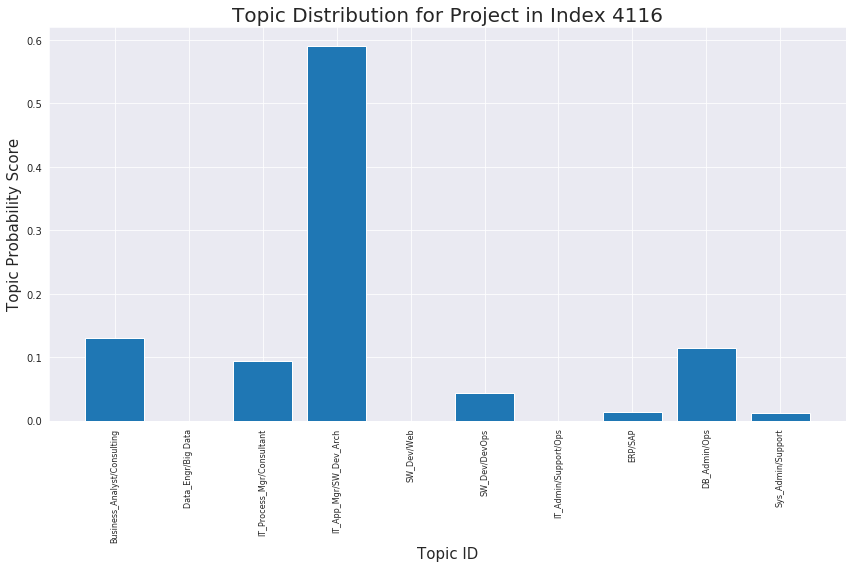

In [599]:
plot_topic_dist(doc_distribution, random_index)

In [553]:
# print the top 5 contributing topics and their words
#for i in doc_distribution.argsort()[-5:][::-1]:
    #print(i, lda.show_topic(topicid=i, topn=10), "\n")

# New Unseen Test Data

In [509]:
doc_index = 0

In [510]:
new_doc_bow = dictionary.doc2bow(test_df.iloc[doc_index,3])

In [511]:
print(test_df.iloc[doc_index,1])

IT-Systembetreuer - Dynamics NAV (m/w/d) für Bremen / 51533


In [512]:
print(test_df.iloc[doc_index,2])

Projektbeschreibung                                            Melden Sie sich jetzt an und bewerben Sie sich direkt!               Jetzt bewerben                                              Für einen unserer Großkunden suchen wir derzeit einen Mitarbeiter zur Direktvermittlung, der die Betreuung der ERP-Umgebung (Microsoft Dynamics Navision, Bau Financials) übernimmt. Ein weiterer Fokus liegt auf der Leitung von Projekten zur Weiterentwicklung des genannten Bereiches. Bei Fragen oder Problemen sind Sie der Ansprechpartner. Ihre Aufgaben:  Erstellung von Anforderungsanalysen, Prozessbeschreibungen und Pflichtenheften Ableitung von Maßnahmen und deren Umsetzung, samt Design und Customizing Testen von Funktionen und Prozessen, Abnahme und Dokumentation der Ergebnisse Koordination externer IT Dienstleister Verantwortung der Konzeption, Einrichtung und Betreuung von Schnittstellen zu angeschlossenen IT-Systemen und Softwarelösungen Berechtigungsvergaben, Updates oder Mandanteneinrichtung 

In [513]:
new_doc_distr = np.array([topic[1] for topic in lda.get_document_topics(bow=new_doc_bow)])

In [514]:
new_doc_distr

array([1.9573441e-04, 2.7876821e-01, 1.9573441e-04, 5.9750187e-01,
       1.9573441e-04, 1.9573441e-04, 1.9573441e-04, 3.0720018e-02,
       1.9573441e-04, 9.1835462e-02], dtype=float32)

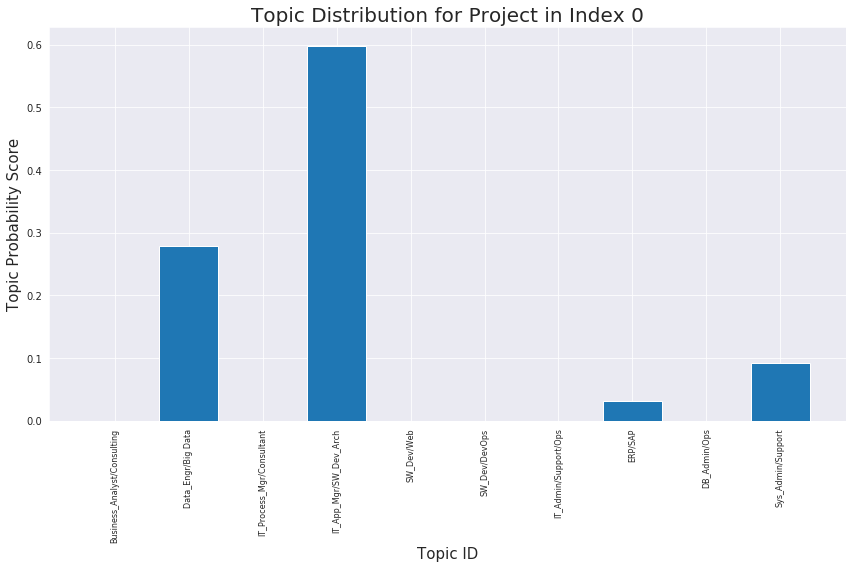

In [600]:
plot_topic_dist(new_doc_distr, doc_index)

In [601]:
# print the top 5 contributing topics and their words
for i in new_doc_distr.argsort()[-5:][::-1]:
    print(i, lda.show_topic(topicid=i, topn=10), "\n")

3 [('dokumentation', 0.018243251), ('technisch', 0.017122477), ('implementier', 0.012348128), ('analys', 0.010804185), ('php', 0.010313732), ('applikation', 0.009793201), ('entwickl', 0.009725381), ('untersttz', 0.009426469), ('besteh', 0.008830481), ('programmier', 0.008808282)] 

1 [('data', 0.06843975), ('dynamics', 0.033581212), ('big', 0.032602843), ('crm', 0.030273866), ('hadoop', 0.025219435), ('ms', 0.015326748), ('microsoft', 0.015083585), ('spark', 0.01413217), ('etl', 0.013812354), ('python', 0.01226743)] 

9 [('windows', 0.07191489), ('support', 0.051333256), ('serv', 0.03801696), ('administration', 0.03757179), ('security', 0.024643537), ('citrix', 0.024250563), ('cisco', 0.022168951), ('microsoft', 0.018868234), ('activ', 0.017786581), ('directory', 0.017201047)] 

7 [('sap', 0.27179933), ('abap', 0.032828238), ('berat', 0.025895901), ('hana', 0.023047566), ('fi', 0.020182319), ('mm', 0.017975865), ('consultant', 0.014863261), ('sd', 0.012247024), ('hcm', 0.011883863), ('

# Finding similar projects

In [499]:
#list of topics distribution in tuples among all documents
#lda[corpus] => genism_lda bow dictionary
all_topic_distr_list = lda[corpus]

In [500]:
#get each topic probablity distr and convert to an array
#simply a list each documents topic distribution
corpus_topic_dist= np.array([[topic[1] for topic in docs] for docs in all_topic_distr_list])
corpus_topic_dist[:3]

array([[2.9332723e-04, 2.9332723e-04, 2.9332723e-04, 3.7692517e-01,
        5.8390123e-01, 2.9332723e-04, 2.9332723e-04, 2.9332723e-04,
        2.9332723e-04, 3.7120324e-02],
       [4.7701594e-01, 3.2159197e-04, 3.2159197e-04, 6.6725083e-02,
        3.2159197e-04, 3.2159197e-04, 3.2159197e-04, 4.5400783e-01,
        3.2159197e-04, 3.2159197e-04],
       [3.2160978e-04, 3.2160978e-04, 6.0050961e-02, 6.0561389e-01,
        3.2160978e-04, 3.2160978e-04, 3.2160978e-04, 3.2160978e-04,
        3.2160978e-04, 3.3208388e-01]], dtype=float32)

In [501]:
#Jensen Shannon Distance calculates the statistical similarity between two documents. 
#The smaller the value , the closer or similare both documents are
#Its symmetric (associative) meaning the similarity value btw A & B is the same btw B & A

def js_similarity_score(doc_distr_query, corpus_distr):
    """
    This function finds the similarity score of a given doc accross all docs in the corpus
    It takes two parameters: doc_distr_query and corpus_distr
    (1) doc_distr_query is the input document query which is an LDA topic distr: list of floats (series)
            [1.9573441e-04,...., 2.7876711e-01]
    (2) corpus_dist is the target corpus containing the LDA topic distr of all documents in the corpus: lists of lists of floats (vector)
            [[1.9573441e-04, 2.7876711e-01, 1.9573441e-04]....[1.9573441e-04,...., 2.7876711e-01]]
    It returns an array containing the similarity score of each document in the corpus_dist to the input doc_distr_query
    The output looks like this: [0.3445, 0.35353, 0.5445,.....]
    
    """
    input_doc = query[None,:].T #transpose input
    corpus_doc = matrix.T # transpose corpus
    m = 0.5*(input_doc + corpus_doc)
    sim_score = np.sqrt(0.5*(entropy(input_doc,m) + entropy(corpus_doc,m)))
    return sim_score

In [502]:
def find_top_similar_docs(doc_distr_query, corpus_distr,n=10):
    """
    This function returns the index lists of the top n most similar documents using the js_similarity_score
    n can be changed to any amount desired, default is 10
    """
    sim_score = js_similarity(doc_distr_query, corpus_distr)
    similar_docs_index_array = sim_score.argsort()[:n] #argsort sorts from lower to higher
    return similar_docs_index_array

In [503]:
# this is surprisingly fast
similar_docs_index = find_top_similar_docs(new_doc_distribution, corpus_topic_dist)

In [504]:
similar_docs_index

array([2016, 3803,  734, 2657, 1319, 3365, 3219, 3900, 1586, 3936])

In [505]:
top_sim_docs = train_df[train_df.index.isin(similar_docs_index)]
top_sim_docs['title']

734          Quality Assurance Manager (m/w/d) - 221-3054
1319                             Senior Backend Developer
1586                            Senior Software Developer
2016                         IT Experte Automatisierungen
2657                             Senior Backend Developer
3219              Senior Java Developer (6 month project)
3365    DevOps Engineer – Build Consultant //EO: Münch...
3803       Azure Developer (m/w/d) for Düsseldorf / 51630
3900       Java, Spring, VueJS FRONTEND Entwickler - Köln
3936    Java Cloud Native / Micro-services Developer f...
Name: title, dtype: object

In [579]:
def predict_bereich(text, lda_model):
    clean = all_processing(text)
    text_bow = dictionary.doc2bow(clean)
    topic_distr_array = np.array([topic[1] for topic in lda_model.get_document_topics(bow=text_bow)])
    plot_topic_dist(topic_distr_array, 1)
    #return topic_distr_array
    for i in topic_distr_array.argsort()[-5:][::-1]:
        print(i, lda_model.show_topic(topicid=i, topn=10), "\n")
    return topic_distr_array, clean
    

In [628]:
a = """

Python Frontend Entwickler (m/w/d) 
Mit rund 1000 angestellten Mitarbeitern und derzeit 500 freien Beratern unterstützen wir namhafte Unternehmen bei der Umsetzung ihrer IT Projekte. 

Für einen unserer Kunden in Berlin suchen wir aktuell auf freiberuflicher Basis einen Data Engineer (m/w/d). 
Aufgabenbeschreibung: 

Aufbau des BI-Frontends
mit Hilfe von Python neue reports/dashboard erstellen, die testgetrieben (integration tests) sind
Aufbau einer lokalen Entwicklungsumgebung
Anforderungen: 

Must haves: 
Python
kubernetes
Nice to haves: 
Dash library
Grafana
BI-Tools (Metabase im Einsatz, Google Data Studio fürs prototyping)
MongoDB, PostgreSQL, S3
jenkins



"""


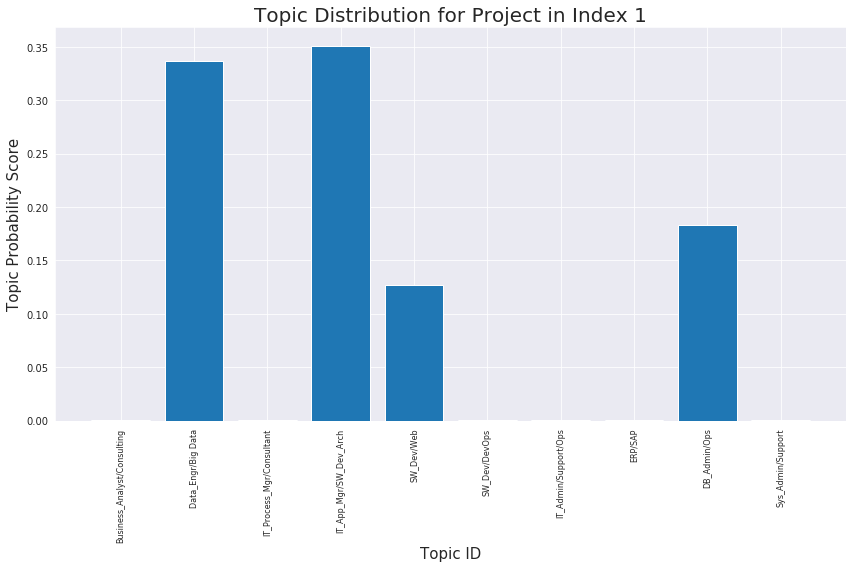

3 [('dokumentation', 0.018243251), ('technisch', 0.017122477), ('implementier', 0.012348128), ('analys', 0.010804185), ('php', 0.010313732), ('applikation', 0.009793201), ('entwickl', 0.009725381), ('untersttz', 0.009426469), ('besteh', 0.008830481), ('programmier', 0.008808282)] 

1 [('data', 0.06843975), ('dynamics', 0.033581212), ('big', 0.032602843), ('crm', 0.030273866), ('hadoop', 0.025219435), ('ms', 0.015326748), ('microsoft', 0.015083585), ('spark', 0.01413217), ('etl', 0.013812354), ('python', 0.01226743)] 

8 [('oracl', 0.06206814), ('sql', 0.04634861), ('net', 0.03717018), ('datenbank', 0.029123241), ('serv', 0.01965954), ('entwickl', 0.018484091), ('ms', 0.017557932), ('sharepoint', 0.014337743), ('gren', 0.012924818), ('untersttz', 0.012400564)] 

4 [('java', 0.09547555), ('entwickl', 0.0327037), ('develop', 0.029436862), ('frontend', 0.027949145), ('javascript', 0.026526), ('spring', 0.024417853), ('angular', 0.018312503), ('html', 0.017877178), ('css', 0.015897006), ('b

In [629]:
t, c = predict_bereich(a, lda2)

In [619]:
c

['data',
 'analystfolg',
 'erwart',
 'generat',
 'analytics',
 'asset',
 'inventory',
 'establish',
 'graph',
 'asset',
 'population',
 'subfleet',
 'age',
 'profil',
 'constructor',
 'graph',
 'pie',
 'chart',
 'histogram',
 'extract',
 'maintenanc',
 'ord',
 'establish',
 'report',
 'maintenanc',
 'planning',
 'ord',
 'execution',
 'perform',
 'cost',
 'analysis',
 'department',
 'cent',
 'asset',
 'fleet',
 'subfleet',
 'retrieving',
 'data',
 'sap',
 'calculat',
 'estimation',
 'model',
 'rebuild',
 'missing',
 'cost',
 'generat',
 'different',
 'cost',
 'analysis',
 'graph',
 'waterfall',
 'pie',
 'chart',
 'lif',
 'cycl',
 'cost',
 'perform',
 'statistical',
 'analysis',
 'incident',
 'data',
 'various',
 'application',
 'fil',
 'correlation',
 'data',
 'different',
 'systemsanforder',
 'general',
 'voltag',
 'electrical',
 'asset',
 'switch',
 'transform',
 'cabl',
 'pylon',
 'prov',
 'data',
 'analysis',
 'data',
 'mining',
 'statistical',
 'analysis',
 'basic',
 'sap',
 'user'